<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/bonespect_trainCTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from glob import glob
import numpy as np
import cv2, os, copy, shutil
import matplotlib.pyplot as plt
from PIL import Image
from random import randint

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model
from skimage.metrics import structural_similarity as ssim


In [2]:
inputDataPath = sorted(glob("/content/drive/MyDrive/Bone_SPECT/norInputData/*.npy"))
labelDataPath = sorted(glob("/content/drive/MyDrive/Bone_SPECT/norLabelData/*.npy"))

In [3]:
totalNum = len(inputDataPath)

In [4]:
testImg = np.load(inputDataPath[0])

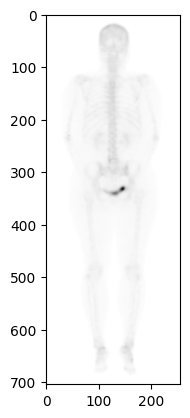

In [5]:
plt.imshow(testImg, cmap='gray_r')
plt.show()

In [6]:
for i in range(totalNum):
    tempInput = inputDataPath[i].split("/")[-1][-22:-14]
    tempLabel = labelDataPath[i].split("/")[-1][-22:-14]
    if tempInput != tempLabel:
        print(i)
    else:
        continue

In [7]:
inputObj = []
labelObj = []
sizesImg = []

for i in range(totalNum):
    tempInputObj = np.load(inputDataPath[i])
    tempInputObj = np.array(tempInputObj, dtype=np.float64)
    tempLabelObj = np.load(labelDataPath[i])
    tempLabelObj = np.array(tempLabelObj, dtype=np.uint16)
    sizesImg.append(np.shape(tempInputObj)[0])
    inputObj.append(tempInputObj)
    labelObj.append(tempLabelObj)

In [8]:
MAX_SIZE = 1024

In [9]:
train_imgs = []
train_lbls = []

In [10]:
for i in range(totalNum):
    io_x, ioy = np.shape(inputObj[i])
    if io_x != MAX_SIZE:
        diffIOx = MAX_SIZE - io_x
        zeroPadding = np.zeros((diffIOx,256))
        tempInput = np.vstack([inputObj[i],zeroPadding])
        tempLabel = np.vstack([labelObj[i],zeroPadding])
        train_imgs.append(tempInput)
        train_lbls.append(tempLabel)
    else:
        train_imgs.append(inputObj[i])
        train_lbls.append(labelObj[i])

In [11]:
temp_train_imgs = np.array(train_imgs)
temp_train_lbls = np.array(train_lbls)

In [12]:
# temp_train_lbls = np.where((temp_train_lbls>=2)&(temp_train_lbls<14),2,temp_train_lbls)
# temp_train_lbls[temp_train_lbls>13]=3

In [12]:
split_num = 800

In [13]:
train_imgs = temp_train_imgs[:split_num,...]
valid_imgs = temp_train_imgs[split_num:,...]
train_msks = temp_train_lbls[:split_num,...]
valid_msks = temp_train_lbls[split_num:,...]

In [14]:
train_imgs = np.array(train_imgs, dtype=np.float32)
train_msks = np.array(train_msks, dtype=np.float32)
valid_imgs = np.array(valid_imgs, dtype=np.float32)
valid_msks = np.array(valid_msks, dtype=np.float32)

train_msks = np.reshape(train_msks, (*train_msks.shape, 1))
valid_msks = np.reshape(valid_msks, (*valid_msks.shape, 1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_msks))
test_dataset = tf.data.Dataset.from_tensor_slices((valid_imgs, valid_msks))

In [15]:
len(train_imgs)

800

In [16]:
train_imgs[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
len(np.unique(train_imgs[0]))

5606

In [18]:
len(np.unique(train_msks[0]))

19

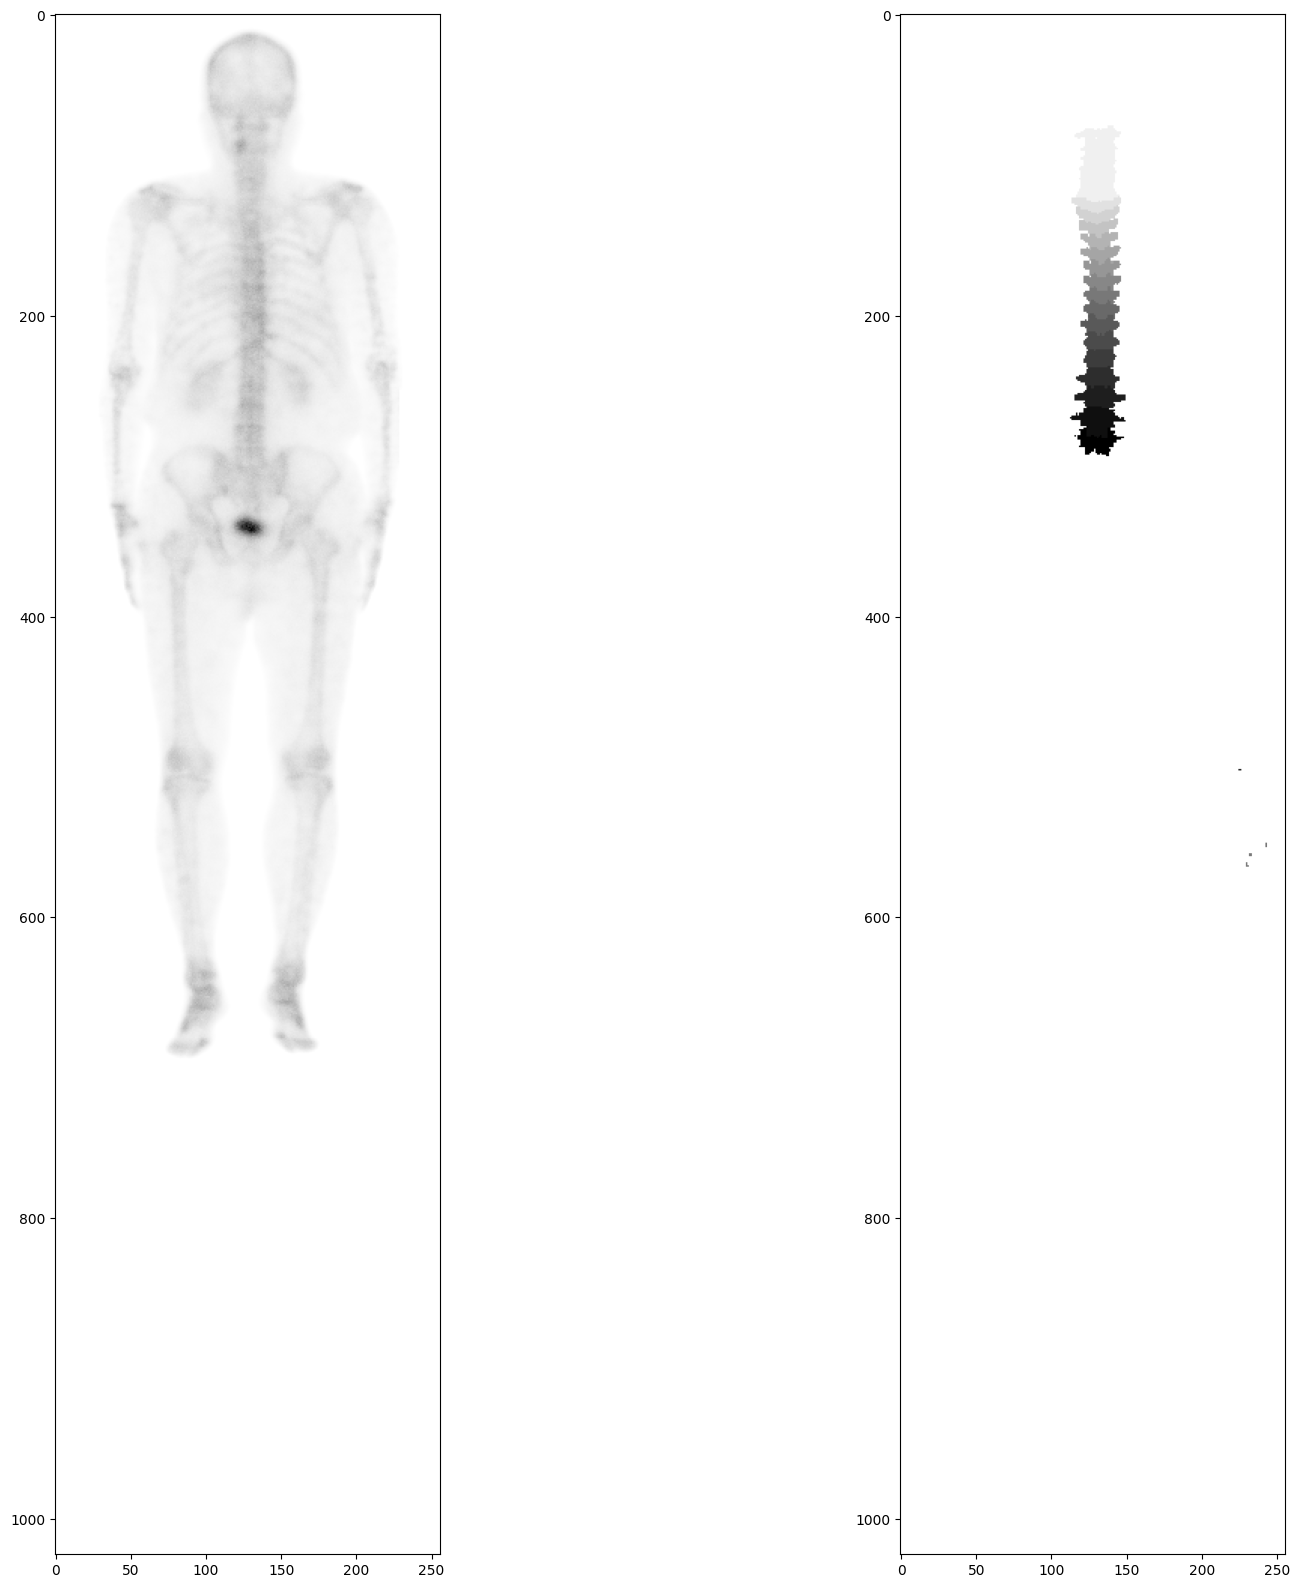

In [19]:
%matplotlib inline

rand_num = randint(1,len(train_imgs))

fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[rand_num]*13, cmap='gray_r')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_msks[rand_num]), cmap='gray_r')

In [20]:
test_img = train_imgs[10] * np.squeeze(train_msks[10])

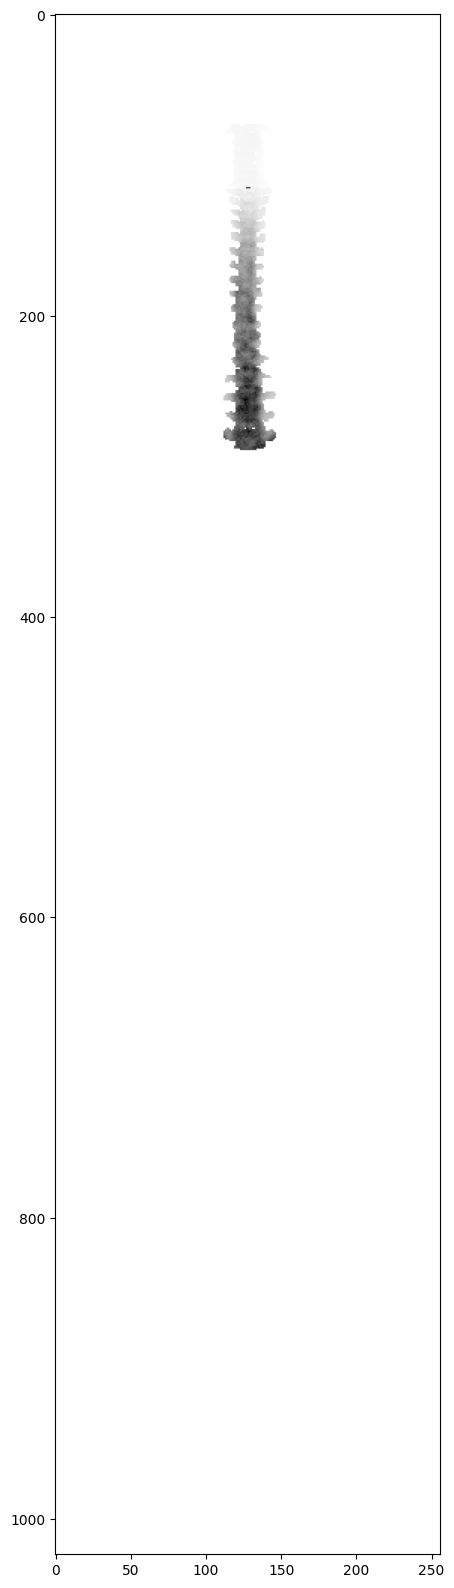

In [21]:
plt.figure(0, figsize=(20, 20))
plt.imshow(test_img, cmap="gray_r")
plt.show()

In [23]:
inputDataPath[10]

'/content/drive/MyDrive/Bone_SPECT/norInputData/23040401_inputData.npy'

In [24]:
inputs = Input((MAX_SIZE, 256, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

In [25]:
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss / 2.0

In [26]:
initial_learning_rate = 9e-7

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=120,
    decay_rate=0.96,
    staircase=True)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Bone_SPECT/models/mymodel_{epoch}.h5",
    save_best_only=True,
    monitor='val_loss',
    verbose=1)]

In [27]:
model.compile(Adam(learning_rate=lr_schedule), bce_dice_loss, metrics=[binary_crossentropy, generalized_dice_coefficient])

In [28]:
history = model.fit(train_imgs, train_msks, batch_size=10, epochs=200, callbacks=callbacks, validation_data=(valid_imgs, valid_msks))

Epoch 1/200
80/80 [==============================] - ETA: 0s - loss: 0.8096 - binary_crossentropy: 0.6962 - generalized_dice_coefficient: 0.0770
Epoch 1: val_loss improved from inf to 0.81014, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


80/80 [==============================] - 38s 238ms/step - loss: 0.8096 - binary_crossentropy: 0.6962 - generalized_dice_coefficient: 0.0770 - val_loss: 0.8101 - val_binary_crossentropy: 0.6928 - val_generalized_dice_coefficient: 0.0726
Epoch 2/200
80/80 [==============================] - ETA: 0s - loss: 0.8078 - binary_crossentropy: 0.6938 - generalized_dice_coefficient: 0.0782
Epoch 2: val_loss improved from 0.81014 to 0.80964, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel_2.h5
80/80 [==============================] - 16s 204ms/step - loss: 0.8078 - binary_crossentropy: 0.6938 - generalized_dice_coefficient: 0.0782 - val_loss: 0.8096 - val_binary_crossentropy: 0.6922 - val_generalized_dice_coefficient: 0.0729
Epoch 3/200
80/80 [==============================] - ETA: 0s - loss: 0.8062 - binary_crossentropy: 0.6917 - generalized_dice_coefficient: 0.0793
Epoch 3: val_loss improved from 0.80964 to 0.80887, saving model to /content/drive/MyDrive/Bone_SPECT/models/mymodel

In [29]:
import pickle
with open("/content/drive/MyDrive/Bone_SPECT/training_history.pkl", 'wb') as file:
    pickle.dump(history.history, file)

In [52]:
del model

In [ ]:
np.shape(train_imgs[0])

In [ ]:
prediction = np.array([train_imgs[0]])

In [ ]:
pred_img = model.predict(prediction)

In [33]:
np.shape(pred_img)

(1, 1024, 256, 1)

In [34]:
pltImg = np.squeeze(pred_img)

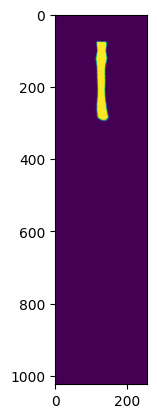

In [35]:
plt.imshow(pltImg)
plt.show()

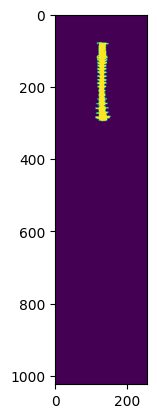

In [36]:
plt.imshow(train_msks[0])
plt.show()

In [ ]:
srcPath = "/content/drive/MyDrive/Bone_SPECT/upload.zip"
dstPath = "/content/drive/MyDrive/Bone_SPECT"

import zipfile

with zipfile.ZipFile(srcPath, 'r') as zip_ref:
    zip_ref.extractall(dstPath)

In [ ]:
predImgPath = "/content/drive/MyDrive/Bone_SPECT/23050201_inputData.npz"
testImg = np.load(predImgPath)['arr_0']

In [ ]:
print(np.shape(testImg))

(731, 256)


In [ ]:
padding_size = MAX_SIZE - np.shape(testImg)[0]

In [ ]:
padding_size

293

In [ ]:
padding_array = np.zeros((293,256))

In [ ]:
outImg = np.vstack([testImg,padding_array])

In [ ]:
np.shape(outImg)

(1024, 256)

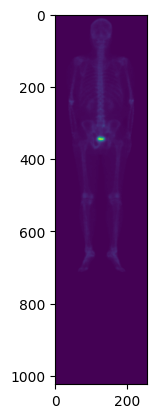

In [ ]:
plt.imshow(outImg)

In [ ]:
from tensorflow.keras.models import load_model

root = "/content/drive/MyDrive/Bone_SPECT/models/mymodel_190.h5"

custom_objects = {"dice_coef":dice_coef, "generalized_dice_coefficient":generalized_dice_coefficient,"dice_loss":dice_loss,"bce_dice_loss":bce_dice_loss}

with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model(root)

In [ ]:
pred_img = model.predict(np.array([outImg]))

1/1 [==============================] - 10s 10s/step


In [ ]:
pltImg = np.squeeze(pred_img)

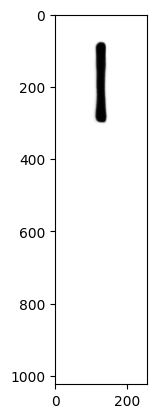

In [ ]:
plt.imshow(pltImg, cmap='gray_r')

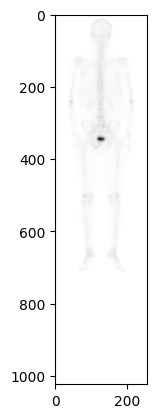

In [ ]:
plt.imshow(outImg,cmap='gray_r')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

inputPath = "/content/drive/MyDrive/Bone_SPECT/23050201_labelData.npy"

img = np.load(inputPath)

In [ ]:
np.shape(img)

(731, 256)

In [ ]:
padding_array = np.zeros((293,256))
outImg = np.vstack([img,padding_array])

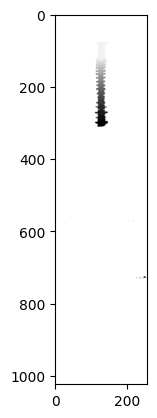

In [ ]:
plt.imshow(outImg, cmap='gray_r')

In [ ]:
outImg[outImg >=1]=1

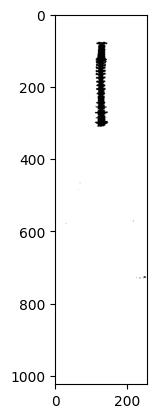

In [ ]:
plt.imshow(outImg, cmap='gray_r')

In [ ]:
outImg = outImg[:,::-1]

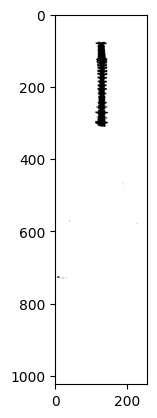

In [ ]:
plt.imshow(outImg, cmap='gray_r')

In [ ]:
!pip install pydicom
import numpy as np
import pydicom
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.1 MB/s eta 0:00:00


In [ ]:
path = "/content/drive/MyDrive/Bone_SPECT/nm630test.dcm"

In [ ]:
fObj = pydicom.dcmread(path)
arrObj = fObj.pixel_array[1]
pred_img = model.predict(np.array([arrObj]))

1/1 [==============================] - 10s 10s/step


In [ ]:
np.shape(pred_img)

(1, 1024, 256, 1)

In [ ]:
plt_img = np.squeeze(pred_img)

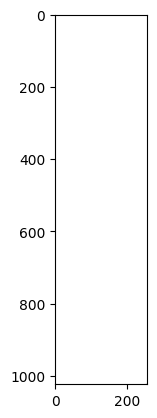

In [ ]:
plt.imshow(plt_img, cmap='gray_r')

In [ ]:
np.max(arrObj)

89

In [ ]:
arrObj = arrObj * 400

In [ ]:
np.max(arrObj)

35600

In [ ]:
arrObj = arrObj / 10

In [ ]:
np.max(arrObj)

3560.0

In [ ]:
arrObj = arrObj*10

In [ ]:
pred_img = model.predict(np.array([arrObj]))

1/1 [==============================] - 0s 289ms/step


In [ ]:
np.shape(pred_img)

(1, 1024, 256, 1)

In [ ]:
plt_img = np.squeeze(pred_img)

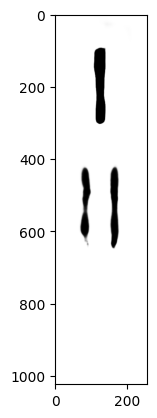

In [ ]:
plt.imshow(plt_img, cmap='gray_r')

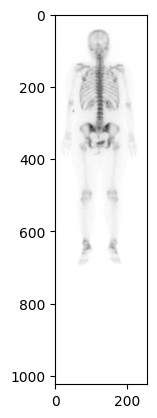

In [ ]:
plt.imshow(arrObj,cmap='gray_r')